In [ ]:
import pandas as pd
import numpy as np
import nltk 
import collections
from nltk.tokenize import RegexpTokenizer
from scipy.stats.stats import pearsonr

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# load trained feature vectors
glove_features = pd.read_table('/Users/vassiki/Desktop/MIND/projects/'
                            'scratch/GloVe-1.2/vectors.txt',header=None)
glove_features.columns = ['vectors']

words_and_vecs = glove_features['vectors'].tolist()
vecs = [[float(v) for v in s.split(" ")[1:]] for s in words_and_vecs]
wl = [s.split(" ")[0] for s in words_and_vecs]
# dimension of each vector is 50 

In [ ]:
# put the vocabulary and vectors together in a data frame
lookup = pd.DataFrame({'words': wl, 'vectors': vecs})

In [ ]:
# get annotations for sherlock dataset

# extract unique words from the annotation
ann_file = '/Users/vassiki/Desktop/MIND/projects/sherlock/Sherlock_Segments_1000_NN_2017.xlsx'
ann_df = pd.read_excel(ann_file)

ann_list = ann_df['Scene Details - A Level '].tolist()

ann_words = [a.encode('ascii','ignore') for a in ann_list]

tokenizer = RegexpTokenizer(r'\w+')

tokens_list = [tokenizer.tokenize(a_string) for a_string in ann_words]
tokens = [t for tok in tokens_list for t in tok]

from nltk.corpus import stopwords

stops = list(stopwords.words('english'))
lower_tokens = [t.lower() for t in tokens]
word_tokens = [w for w in lower_tokens if w not in stops]

print "We discarded {0} stop words".format(len(tokens)-len(word_tokens))

# let's get just the unique words

unique_words = list(set(word_tokens))

print "We have {0} unique words from the original {1}".format(len(unique_words),
                                                             len(word_tokens))

In [ ]:
# retain feature vectors only for unique words in the annotation

# creating lookup table for words uniquely in the dataframe
here_counter = 0
not_here_counter = 0
word_vectors = []
for i,widx in enumerate(unique_words):
    if i in range(100,2000,100):
        print ("working on the {0}th word").format(i)
    if widx in lookup['words'].tolist():
        where_idx = lookup.index[lookup['words'] == widx][0]
        word_vectors.append(lookup['vectors'][where_idx])
        #print "{0} is here".format(widx)
        here_counter += 1
    else:
        #print "{0} isn't here".format(widx)
        word_vectors.append(([0]*len(lookup['vectors'][0])))
        not_here_counter += 1   
        
assert len(word_vectors) == len(unique_words)

In [ ]:
unique_lookup = pd.DataFrame({'words':unique_words,'vectors':word_vectors})

In [ ]:
print "Out of {0} words, we have features for {1} \
and not for {2}".format(len(unique_words),
                        here_counter,not_here_counter)

In [ ]:
# create a copy of the dataframe
# get the column with words from sherlock

df = ann_df.copy()
# remove non ascii chars

# first clean up words in the rows
df["Words"] = ""
#for idx,row in enumerate(df['Scene Details - A Level ']):
for idx in range(df.shape[0]):
    row = df['Scene Details - A Level '][idx]
    if pd.isna(row):
        iter_row = str(row)
    else:
        iter_row = row.encode('ascii','ignore')
    #df.at[idx,"Words"] = [a.encode('ascii','ignore') 
    #                      for a in iter_row.split(" ")]
    asciify = [a.encode('ascii','ignore') 
                          for a in iter_row.split(" ")]
    
    # create tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens_list = [tokenizer.tokenize(a_string) for a_string in asciify]
    # now we are discarding function words
    tokens = [t.lower() for tok in tokens_list for t in tok if t.lower() not in stops]
    
    # lets also remove repetitions of the same word for each row
    non_rep_toks = list(set(tokens))
    
    df.at[idx,"Words"] = non_rep_toks


In [ ]:
# now that we have features for the unique words, we can go through a lookup
# table created by these words an their features in the annotation data frame
df["Word Vectors"] = ""

for idx in range(df.shape[0]):
    if idx in range(200,1000,200):
        print "Working on word {0}".format(idx)
    word_vec=[]
    tr_words = df["Words"][idx]
    for tr_word in tr_words:
        if tr_word.lower() in unique_lookup['words'].tolist():
            where_idx = unique_lookup.index[unique_lookup['words'] 
                                        == tr_word.lower()][0]
            word_vec.append(unique_lookup['vectors'][where_idx])
        else:
            word_vec.append(([0]*len(lookup['vectors'][0])))
    df.at[idx,"Word Vectors"] = word_vec


In [ ]:
# now we create a new column that simply averages the word vectors
# for each TR

df["Average Vector"] = [np.mean(row,axis=0) for row in df["Word Vectors"]]
df["Semantic Point"] = [np.mean(row) for row in df["Word Vectors"]]

df["Surprise Diff"] = df["Semantic Point"].diff()

In [ ]:
# more ideas: feature vectors for only dialog in a given segment,
#             compare with feature vectors all description in each segment  

In [ ]:
# add them up

In [ ]:
x = df["Semantic Point"] 

plt.figure(figsize=(15,20))
plt.plot(x)
plt.show()

In [292]:
scene_start_bool = df["Scene Segments"].isnull()
# this function actually returns some empty unicodes,
# we have to purge them
indices = scene_start_bool[scene_start_bool==False].index.tolist()

scene_start_names = df.iloc[indices]["Scene Segments"]
keep_scenes = scene_start_names[scene_start_names != u' ']
scene_start_indices = keep_scenes.index.tolist()
scene_start_indices.append(df.shape[0])

In [294]:
df["Segment Vector"] = ""

seg_info = {"segment":[],"value":[],"annot":[]}
for i,val in enumerate(scene_start_indices[:-1]):
    bounds = [val,scene_start_indices[i+1]]
    # take average of all features vectors within a segment
    #fv_avg = np.mean(df.iloc[bounds[0]:bounds[1]]["Semantic Point"])
    fv_avg = np.mean(df.iloc[bounds[0]:bounds[1]]["Average Vector"])
    #df.at[bounds[0]:bounds[1],"Semantic Vector"] = fv_avg  
    seg_info["segment"].append("segement{0}".format(i+1))
    seg_info["value"].append(fv_avg)
    seg_info["annot"].append(df.iloc[val]["Scene Segments"])
    
cm_df = pd.DataFrame(seg_info)

In [296]:
# create correlation matrix
#cm = np.zeros((cm_df.shape[0],cm_df.shape[0]))

vec_for_corr = cm_df["value"].tolist()
corr_vec = [pearsonr(x,y)[0] for x in vec_for_corr for y in vec_for_corr]
cm = np.reshape(corr_vec,(cm_df.shape[0],cm_df.shape[0]))

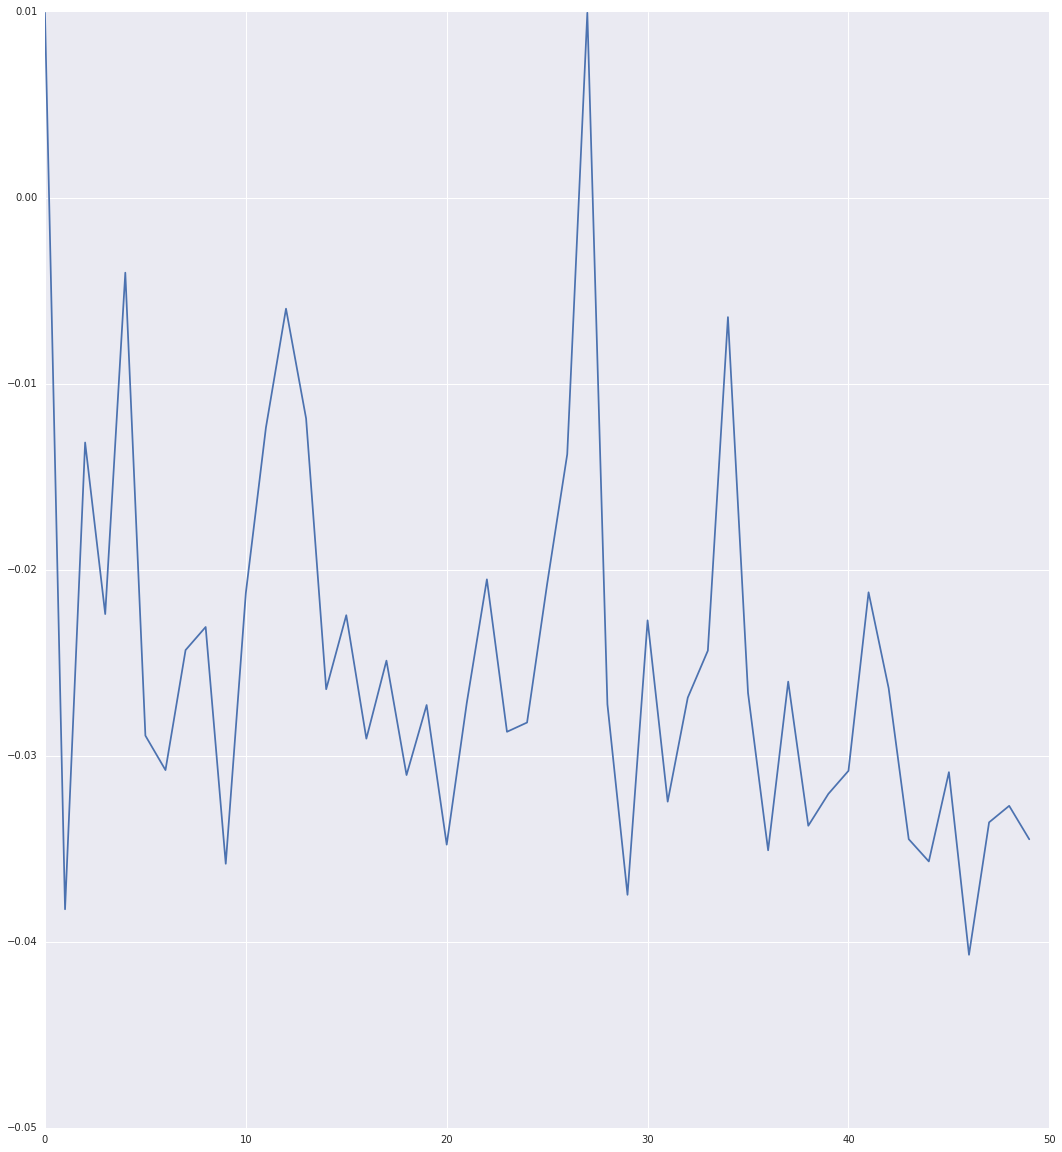

In [304]:
x = [np.mean(vec) for vec in cm_df["value"]] 

plt.figure(figsize=(18,20))
plt.plot(x)
plt.show()

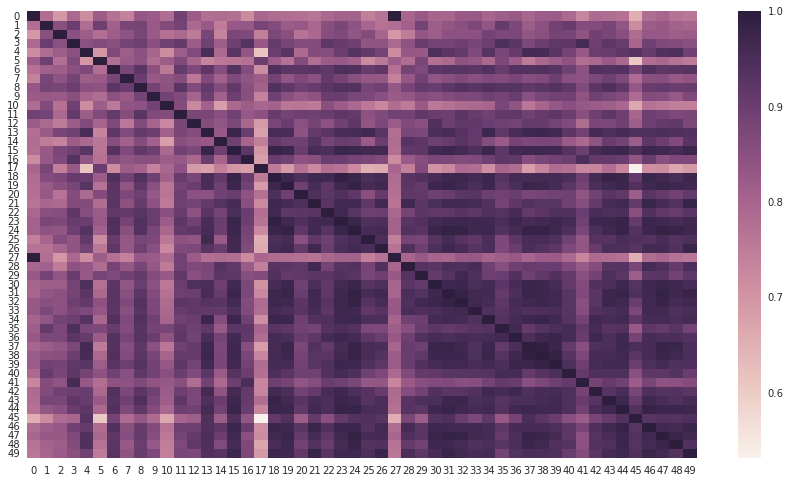

In [305]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.heatmap(cm)